In [1]:
from ngsolve import *
from ngsolve.meshes import MakeStructured3DMesh

## choose this option to draw in interactive window or jupyter
from ngsolve.webgui import Draw
## choose this option for a separate gui window
# import netgen.gui

import numpy as np
import matplotlib.pyplot as plt

# Kinematic description of deformations

Body of interest is the unit cube. In this tutorial, a displacement field $\vec u$ is prescribed, and strains are evaluated.

In [2]:
mesh = MakeStructured3DMesh(hexes = True, nx = 5)
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

Displacment field is a finite element grid function - not important for now.

In [4]:
u = GridFunction(VectorH1(mesh))
sceneu = Draw(u, mesh, "u")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

We can set $\vec u$ to any function that comes to mind - e.g. uniaxial extension or shear

In [5]:
u.Set( CoefficientFunction((0.1*x, 0, 0)) )
sceneu.Redraw()

In [7]:
# u.Set( CoefficientFunction((0.1*z, 0, 0)) )
# sceneu.Redraw()

### Displacement gradient
$\mathbf{G} = (\nabla \vec u)^T$ and $\mathbf{F} = \mathbf{I} + \mathbf{G}$

Close and reopen visualization dialog if necessary

Why "BoundaryFromVolumeCF"? Gradients are not unique on interfaces (there can be a different value on the left and right hand side of the interface). Therefore, ngsolve draws only those parts that are conforming. Using "BoundaryFromVolumeCF", it is forced to use the full gradient on the outside, and either one or the other on an internal interface. This may look strange on internal interfaces, see stresses later!

In [8]:
G = Grad(u)
F = G + Id(3)

## tensor/matrix function: choose the component to be drawn, here: [0]
sceneg = Draw(BoundaryFromVolumeCF(G)[0], mesh, "G")
scenef = Draw(BoundaryFromVolumeCF(F)[0], mesh, "F")

In [9]:
def deformationgradient(u):
    return Grad(u) + Id(3)

### Linearized strain tensor
$\boldsymbol{\varepsilon} = \frac{1}{2} (\mathbf{G} + \mathbf{G}^T)$

In [10]:
epsilon = 0.5*(G + G.trans)

sceneeps = Draw(BoundaryFromVolumeCF(epsilon)[0], mesh, "epsilon")

In [12]:
def linearizedstrain(u): 
    return 0.5*(Grad(u) + Grad(u).trans)

### Green strain
$\mathbf{E} = \frac{1}{2} (\mathbf{G} + \mathbf{G}^T + \mathbf{G}^T \cdot \mathbf{G}) = \frac{1}{2}(\mathbf{F}^T \cdot \mathbf{F} - \mathbf{I})$

In [13]:
def Greenstrain(u):
    return 0.5*(deformationgradient(u).trans*deformationgradient(u) - Id(3))

In [14]:
E = Greenstrain(u)

sceneE = Draw(BoundaryFromVolumeCF(E)[0], mesh, "E")

### Right/left Cauchy-Green tensor
$\mathbf{C} = \mathbf{F}^T \cdot \mathbf{F}$ and $\mathbf{b} = \mathbf{F} \cdot \mathbf{F}^T$ 

In [15]:
def rightCauchyGreen(u):
    return deformationgradient(u).trans*deformationgradient(u) 

def leftCauchyGreen(u):
    return deformationgradient(u)*deformationgradient(u).trans

In [16]:
C = rightCauchyGreen(u)
b = leftCauchyGreen(u)

Draw(BoundaryFromVolumeCF(C)[0], mesh, "C")
Draw(BoundaryFromVolumeCF(b)[0], mesh, "b")

### Almansi strain tensor
$\mathbf e = \frac{1}{2}(\mathbf{I} - \mathbf{b}^{-1})$

In [17]:
def Almansi(u):
    return 0.5*(Id(3) - Inv(leftCauchyGreen(u)))

e = Almansi(u)

Draw(BoundaryFromVolumeCF(e)[0], mesh, "e")

## displacement-strain curves

$\vec u = ux\, x \vec e_x$, $ux$ is the lateral displacement of the cube's face when the opposite face is fixed.

In [18]:
uvals = np.linspace(-0.01,0.01,5)
# uvals = np.linspace(-0.1,0.1,5)
# uvals = np.linspace(-0.9,1,50)

epsilonvals = []
Evals = []
evals = []

for ux in uvals:
    u.Set( CoefficientFunction((ux*x, 0, 0)) )

    # evaluate at mesh center point (0.5,0.5,0.5)
    epsilonvals.append(linearizedstrain(u)[0](mesh(0.5,0.5,0.5)) )
    Evals.append(Greenstrain(u)[0](mesh(0.5,0.5,0.5)) )
    evals.append(Almansi(u)[0](mesh(0.5,0.5,0.5)) )




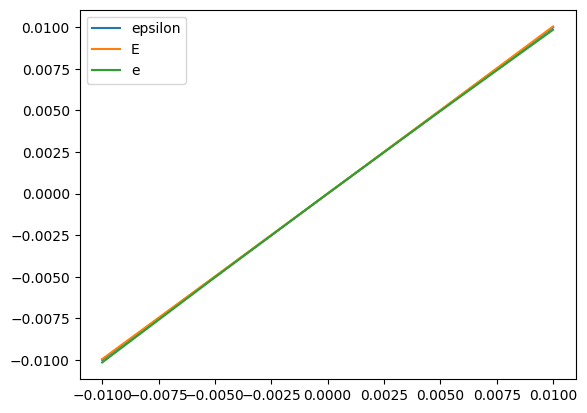

In [19]:
plt.plot(uvals, epsilonvals, label="epsilon")
plt.plot(uvals, Evals, label="E")
plt.plot(uvals, evals, label="e")
plt.legend()

## Rotations

In [21]:
u.Set( 0.1*CoefficientFunction((-y, x, 0)) )

In [23]:
alpha = 0.1
u.Set( CoefficientFunction((cos(alpha)*x-sin(alpha)*y-x, sin(alpha)*x+cos(alpha)*y-y, 0)) )